In [251]:
import os
import sys
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import seaborn as sns

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.Wordle import Wordle

In [2]:
# word list with frequencies
wl = pd.read_csv(r'..\data\processed\wordle_google_freq_word_list.csv', index_col=0)
alphabet = 'abcdefghijklmnopqrstuvwxyz'
# Read in  Bags of Words matrices: 
with open(r'..\data\processed\bags_of_words.json', 'r') as infile:
    all_bow = json.load(infile, parse_int=False)
bow17 = all_bow['combined_wordle_google']
bowwordle = all_bow['all_wordle']
bowcur = all_bow['wordle_curated']

bow17lfl = calc_lfl(wl.index, bow17, colname='all')
bowwordlelfl = calc_lfl(wl.loc[wl['in_wordle']].index, bowwordle, colname='wordle')
bowcurlfl = calc_lfl(wl.loc[wl['in_wordle_curated']].index, bowcur, colname='curated')

lfl = pd.concat([bow17lfl, bowwordlelfl, bowcurlfl], axis=1, sort=True)
# lfl.to_csv(r'..\data\processed\letter_freq_likelihoods.csv')

{'0': {'a': 0.06090712742980561,
  'b': 0.07473002159827213,
  'c': 0.08552915766738661,
  'd': 0.04794816414686825,
  'e': 0.031101511879049675,
  'f': 0.05874730021598272,
  'g': 0.04967602591792657,
  'h': 0.029805615550755938,
  'i': 0.01468682505399568,
  'j': 0.008639308855291577,
  'k': 0.008639308855291577,
  'l': 0.03801295896328294,
  'm': 0.04622030237580994,
  'n': 0.015982721382289417,
  'o': 0.017710583153347732,
  'p': 0.061339092872570194,
  'q': 0.009935205183585313,
  'r': 0.04535637149028078,
  's': 0.15809935205183584,
  't': 0.06436285097192225,
  'u': 0.014254859611231102,
  'v': 0.018574514038876888,
  'w': 0.035853131749460046,
  'x': 0.0,
  'y': 0.002591792656587473,
  'z': 0.0012958963282937365},
 '1': {'a': 0.13131749460043196,
  'b': 0.006911447084233261,
  'c': 0.017278617710583154,
  'd': 0.008639308855291577,
  'e': 0.10453563714902808,
  'f': 0.0034557235421166306,
  'g': 0.005183585313174946,
  'h': 0.06220302375809935,
  'i': 0.08725701943844492,
  'j'

In [62]:
def calc_lfl(word_list, bow, colname):
    """    
    Calculate Likelihood of word from Letter Frequency given in a bag of words 5x26 matrix 
        see BJA-01.2-make-word-lists
    """
    result = []
    for word in word_list:
        likelihood = 1
        for i, letter in enumerate(word):
            likelihood *= bow[str(i)][letter]
        result.append((word, likelihood))
    return pd.DataFrame(sorted(result, key=lambda x: x[1], reverse=True), columns=['w', colname]).set_index('w') 
    
    
def contains_any(word1, word2, max_repeat=0):
    """ Check whether word1 contains any of the letters in word2. """
#     set_ = set(x for x in str2)
#     return 1 in [c in str1 for c in set_]
    return any(letter in word1 for letter in word2)


def total_green_letter_prob(word, bow=bowcur):
    # Finds total probability that you will get at least 1 green in any position by testing this word
    prob = 0
    for i, letter in enumerate(word):
        prob += bow[str(i)][letter]
    return prob

def prob_of_2_greens(word):
    # How do you calculate this? 
    pass

def total_yellow_letter_prob(word):
    prob = 0 
    
    
# Allow for repeat letters with max_repeats
def contains_repeats(word, search, max_repeats):
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return False
    else:
        return True

# Question

## What sequence of words provides the highest chance of finding greens and yellows, while also not repeating any letters (i.e. maximizing grays)? 

### Make a function that iterates through the top 200 words with highest letter-frequency probability and finds the sequence of 5 words that has no repeats 
### If it can't find a next word with no repeat, then take the word with just one repeat (i.e. len(set(word)) == 4) 
### Then sum the calculated letter-freq probabilities of all the words 

### This will give a probability of finding a green but it doesn't include the helpful contribution from simply covering more letters and finding more grays. 
### To account for grays, include a "if you have X gray letter, what % of words are excluded?"

# Very important! The dataset for this optimization must use the entire wordle list, but with their letter-freq probabilities calculated from the curated list. 

## Then use the top 200 from curated as starting points for the calculation.

In [9]:
data = wl.loc[wl['in_wordle'], ['in_wordle_curated']]
data['wp'] = calc_lfl(data.index, bowcur, colname='wp')   # wp = Word Probability from letter frequency

# tglp = Total Green Letter Probability
# sum of all probabilities of finding that letter in that position 
data['tglp'] = data.index.map(lambda x: total_green_letter_prob(x)) 
curated_sorted = data.sort_values(['in_wordle_curated', 'tglp'], ascending=False)
curated_words = curated_sorted.loc[curated_sorted['in_wordle_curated']].index
display(curated_words)
data = data.sort_values('tglp', ascending=False)
data['unique_letters'] = data.index.map(lambda x: len(set(x)))
data.head(10)

Index(['slate', 'sauce', 'slice', 'shale', 'saute', 'share', 'sooty', 'shine',
       'suite', 'crane',
       ...
       'lymph', 'jumbo', 'igloo', 'ethic', 'unzip', 'umbra', 'affix', 'ethos',
       'inbox', 'nymph'],
      dtype='object', name='w', length=2315)

,in_wordle_curated,wp,tglp,unique_letters
w,,,,
saree,False,0.000037,0.680346,4
sooey,False,0.000043,0.678618,4
soree,False,0.000034,0.669546,4
saine,False,0.000034,0.666091,5
soare,False,0.000030,0.660043,5
saice,False,0.000029,0.653132,5
sease,False,0.000030,0.652268,3
seare,False,0.000026,0.644060,4
seine,False,0.000027,0.639309,4


In [169]:
all_words = set([word.upper() for word in data.index])
counter = 0
for word in data[data['in_wordle_curated']].index:
    w = Wordle(word, ben_mode=False, all_words=all_words)
    if w.try_word('saine')[0] > 0:
        counter += 1
print(counter)
print(counter/2315)

1163
0.5023758099352051


0.6660907127429806

In [174]:
r = []
for word in curated_words:
    for c1, c2 in zip('saine', word):
        if c1 == c2:
            r.append(1)
#         break
print(sum(r))
print(1542/2315)
print(total_green_letter_prob('saine', bow=bowcur))

# Conclusion: the total green letter prob is equivalent to the total number of greens you'd get if you tested
#   the word on every possible word in 2315 list. 

1542
0.6660907127429806
0.6660907127429806


### The number you get from calculating by sum(bow[i][letter]) isn't actually the probability you'll get a get at least 1 green, it's the total number of greens you'll get across all words, which is a different metric but a useful one. 

<AxesSubplot:>

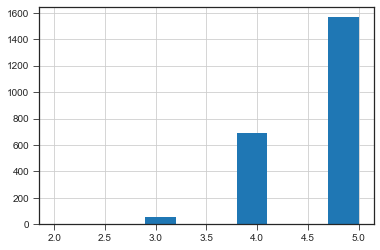

In [252]:
data[data['in_wordle_curated']]['unique_letters'].hist()

In [240]:
ul.value_counts()

5    1566
4     691
3      57
2       2
1       1
dtype: int64

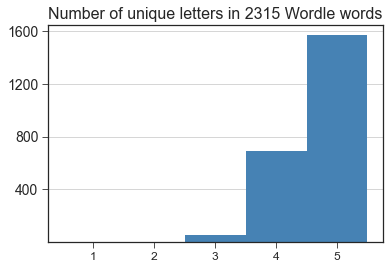

In [258]:
ul = data[data['in_wordle_curated']]['unique_letters']
ul = ul.append(pd.Series({'dummy2': 1, 'dummy3': 2}))
ul.hist(bins=5, color='steelblue')
plt.title('Number of unique letters in 2315 Wordle words', fontsize=16)
plt.xticks([1.4,2.2,3,3.8, 4.6,], ['1','2','3','4','5'], fontsize=12)
plt.yticks([400,800,1200,1600],fontsize=14)
plt.grid(alpha=0.0, axis='x')
plt.savefig(r'..\reports\figures\num_unique_letters_in_words.svg', bbox_inches='tight')

In [302]:
data[data['unique_letters']==2]

,in_wordle_curated,wp,tglp,unique_letters
w,,,,
peepe,False,1.939357e-06,0.447084,2
taata,False,1.860536e-06,0.415983,2
anana,False,6.597405e-07,0.337365,2
susus,False,2.417939e-07,0.323974,2
cocco,False,4.101796e-07,0.320950,2
nanna,False,2.738965e-07,0.313607,2
mamma,True,1.298737e-07,0.260907,2
ayaya,False,2.874958e-09,0.232397,2
esses,False,1.586781e-08,0.225486,2


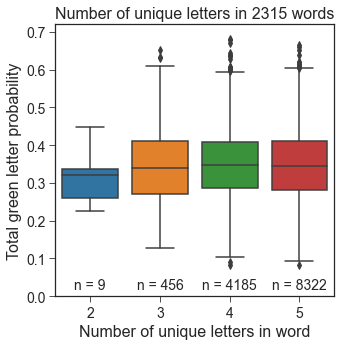

In [300]:
sns.boxplot(x='unique_letters', 
               y='tglp',
#                scale='count',
               data=data,
#                order=['2', '3', '4', '5'], 
               orient='v')
plt.ylim((0, 0.72))
plt.annotate('n = 9', xy=(0, 0.02), fontsize=14, ha='center')
plt.annotate('n = 456', xy=(1, 0.02), fontsize=14, ha='center')
plt.annotate('n = 4185', xy=(2, 0.02), fontsize=14, ha='center')
plt.annotate('n = 8322', xy=(3, 0.02), fontsize=14, ha='center')

plt.gcf().set_size_inches((5, 5))
plt.title('Number of unique letters in 2315 words', fontsize=16)
plt.xticks(fontsize=14)
plt.xlabel('Number of unique letters in word', fontsize=16)
plt.ylabel('Total green letter probability', fontsize=16)
plt.yticks(fontsize=14)

plt.savefig(r'..\reports\figures\TGLP_vs_num_unique_letters.svg', bbox_inches='tight')

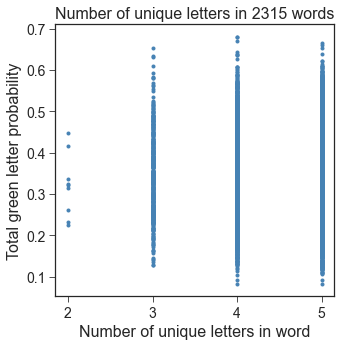

In [272]:
plt.scatter(data['unique_letters'], data['tglp'], color='steelblue', marker='.')
plt.gcf().set_size_inches((5, 5))
plt.title('Number of unique letters in 2315 words', fontsize=16)
plt.xticks([2,3,4,5], [2,3,4,5], fontsize=14)
plt.xlabel('Number of unique letters in word', fontsize=16)
plt.ylabel('Total green letter probability', fontsize=16)
plt.yticks(fontsize=14)

plt.savefig(r'..\reports\figures\num_unique_letters_vs_TGLP.svg', bbox_inches='tight')

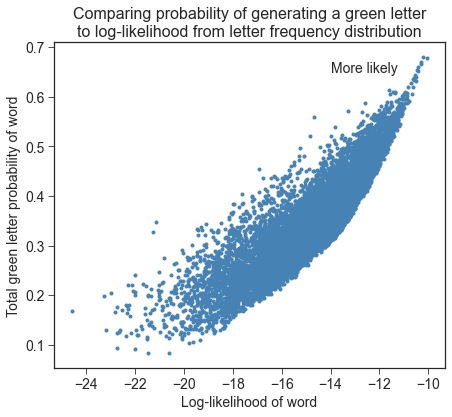

In [202]:
plt.scatter(np.log(data['wp']), data['tglp'], c='steelblue', marker='.')
plt.gcf().set_size_inches((7,6))
plt.ylabel('Total green letter probability of word', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Log-likelihood of word', fontsize=14)
plt.xticks(fontsize=14)
plt.annotate('More likely', xy=(-14, 0.65), fontsize=14)
plt.title('Comparing probability of generating a green letter\n'
          'to log-likelihood from letter frequency distribution', fontsize=16)
plt.savefig(r'..\reports\figures\prob_green_vs_llh.svg', bbox_inches='tight')

In [108]:
words = data.sort_values('tglp', ascending=False).index
tglp_list = data['tglp'].to_list()

start_words_list = data.loc[data['in_wordle_curated']].index
result = []
for i, start_word in enumerate(words[0:1000]):
    num_repeat_letters = 5 - len(set(start_word))  # Start with number of repeats in start_word 
    combined_words = start_word
    summed_tglp = data.loc[start_word, 'tglp']
    sequence = []
    for seq_index in range(5):
        for test_word, tglp in zip(words, tglp_list): 
            if not contains_any(test_word, combined_words) and (len(set(test_word)) == 5):
                sequence.append(test_word)
                summed_tglp += tglp
                combined_words += test_word
                break
            if test_word == 'imshi':
                # very last word was reached without finding a test_word with 5 unique letters
                # therefore it should test for len(set(test_word)) == 4
                for test_word, tglp in zip(words, tglp_list): 
                    if not contains_repeats(test_word, combined_words, 0) and (len(set(test_word)) >= 4):
                        num_repeat_letters += 1
                        sequence.append(test_word)
                        summed_tglp += tglp
                        combined_words += test_word
                        break
                        
                if test_word == 'imshi':
                    # very last word was reached without finding a test_word with 4 unique letters and at most 1 repeat
                    # therefore it should test for len(set(test_word)) == 4 and at most 1 repeat
                    for test_word, tglp in zip(words, tglp_list): 
                        if not contains_repeats(test_word, combined_words, 1) and (len(set(test_word)) >= 4):
                            num_repeat_letters += 1
                            sequence.append(test_word)
                            summed_tglp += tglp
                            combined_words += test_word
                            break
                        
    result.append((start_word, summed_tglp, num_repeat_letters, sequence))

In [109]:
result

# save result file from search
# with open(r'..\data\processed\optimum_words_result.json', 'w') as outfile:
#     json.dump(result, outfile)

[('saree', 1.5904967602591793, 1, ['bliny', 'chout']),
 ('sooey', 1.7442764578833694, 2, ['brant', 'child', 'jugum']),
 ('soree', 1.9416846652267816, 2, ['gaily', 'bundt', 'chack']),
 ('saine', 1.722246220302376, 1, ['borty', 'pluck', 'whiff']),
 ('soare', 1.4742980561555075, 0, ['bliny', 'dutch']),
 ('saice', 1.7624190064794816, 1, ['drony', 'flump', 'thigh']),
 ('sease', 1.9287257019438444, 3, ['crony', 'built', 'khaph']),
 ('seare', 1.5542116630669547, 1, ['bliny', 'chout']),
 ('seine', 1.8855291576673867, 2, ['coaly', 'brugh', 'tempt']),
 ('slane', 1.524406047516199, 0, ['pricy', 'fouth']),
 ('soole', 1.7606911447084235, 2, ['briny', 'chapt', 'jugum']),
 ('siree', 1.8414686825053992, 2, ['coaly', 'bundt', 'khaph']),
 ('seise', 1.9347732181425483, 3, ['coaly', 'brunt', 'khaph']),
 ('cooee', 1.88207343412527, 2, ['slaty', 'brink', 'whump']),
 ('soote', 1.8622030237580995, 2, ['briny', 'cauld', 'khaph']),
 ('slate', 1.700647948164147, 1, ['crony', 'guimp', 'whiff']),
 ('soily', 1.7879

In [129]:
rdf = pd.DataFrame(result)
rdf.columns = ['w', 'sum_tglp', 'repeat_letters', 'next_guesses']
rdf = rdf.set_index('w')
rdf.sort_values(['repeat_letters', 'sum_tglp'], ascending=[True, False])
rdf['num_unique_lett'] = (rdf['next_guesses'].str.len() * 5 + 5) - rdf['repeat_letters']
rdf['mean_tglp'] = rdf['sum_tglp'] / rdf['num_unique_lett']
rdf.sort_values('mean_tglp', ascending=False).head(50)

,sum_tglp,repeat_letters,next_guesses,num_unique_lett,mean_tglp
w,,,,,
allee,1.539957,2,"[shiny, court]",13,0.118458
mamee,1.989201,3,"[soily, brunt, chack]",17,0.117012
puree,1.621598,1,"[soily, chant]",14,0.115828
pewee,1.962419,3,"[soily, brant, chuck]",17,0.115436
haily,1.612527,1,"[souce, brant]",14,0.115180
chace,1.599136,1,"[soily, brunt]",14,0.114224
raree,1.937365,3,"[soily, bundt, chack]",17,0.113963
seise,1.934773,3,"[coaly, brunt, khaph]",17,0.113810
saree,1.590497,1,"[bliny, chout]",14,0.113607


In [159]:
wordle_curated_words = [x.upper() for x in data['in_wordle_curated'].index]

def word_filter(output, word_list=all_words):
    """
    Takes in output from Wordle class and filters the list of words for possible corrects.
    Returns list of words that could still be correct. 
    """
    greens, yellows, absent_letters = output
    absent_filter = []
    for word in word_list:
        if not any(letter in word for letter in absent_letters):
            absent_filter.append(word)
            
    yellow_filter = []
    for word in absent_filter:
        if all(letter in word for letter in yellows):  # checks for presence of yellows in all words
            yellow_filter.append(word)
            
    final = []
    for word in yellow_filter: 
        if all(letter == word[i] for i, letter in enumerate(greens) if letter is not None):
            final.append(word)
        
    return final

In [160]:
filt = []
count = 0

for i, row in rdf.iterrows():
    
    guesses = row['next_guesses']
#     print(i, guesses)
    w = Wordle(i, ben_mode=True)
#     for word in guesses[:-1]:
    w.try_word(guesses[0])
    f = word_filter(w.try_word(guesses[1]), word_list=wordle_curated_words)
    filt.append((i, len(f)))
#     count += 1
#     if count == 10:
#         break

# for word in word_list:
#     w = Wordle(word, ben_mode=True)
#     w.try_word('SAINT')
#     w.try_word('CORED')
#     w.try_word('BULKY')
#     f = word_filter(w.try_word('WHOMP'))
#     filt.append((len(f), f))

In [168]:
remaining_possible_words_using_only_3_total_guesses = pd.DataFrame(filt, columns=['w', 'remaining_words']).set_index('w')
rdf = rdf.join(remaining_possible_words_using_only_3_total_guesses)
rdf.sort_values('remaining_words')

,sum_tglp,repeat_letters,next_guesses,num_unique_lett,mean_tglp,remaining_words
w,,,,,,
slyly,1.738229,3,"[crane, quoit, khaph]",17,0.102249,16
diary,1.797408,2,"[souce, plant, whiff]",18,0.099856,35
bialy,1.905832,2,"[souce, trant, khaph]",18,0.105880,46
pricy,1.524406,0,"[slane, fouth]",15,0.101627,72
briny,1.540389,0,"[slate, pouch]",15,0.102693,78
...,...,...,...,...,...,...
strae,1.406479,0,"[bliny, pouch]",15,0.093765,925
salep,1.550324,1,"[crony, whift, jugum]",19,0.081596,927
spale,1.621166,1,"[crony, whift, jugum]",19,0.085325,927


In [56]:
# If you show that letter X is gray, what percent of words are excluded?
# incl dictionary gives what proportion of words contain that letter 
incldf = []
for wlist in [wl.index, 
              wl[wl['in_wordle']].index, 
              wl[wl['in_wordle_curated']].index]:
    incl = {letter: 0 for letter in alphabet}
    for word in wlist:
        for letter in incl:
            if letter in word:
                incl[letter] += 1
    for key, val in incl.items():
        incl[key] = val/len(wlist)
    incldf.append(incl)
incldf = pd.DataFrame(incldf).T
incldf.columns = ['all', 'wordle', 'curated']
incldf

,all,wordle,curated
a,0.435218,0.410885,0.392657
b,0.117559,0.117098,0.115335
c,0.144739,0.148011,0.193521
d,0.169974,0.177151,0.159827
e,0.447001,0.439793,0.456156
f,0.069757,0.076318,0.089417
g,0.117670,0.118949,0.129590
h,0.137902,0.131668,0.163715
i,0.290923,0.276673,0.279482
j,0.026513,0.022279,0.011663


In [113]:
# excldf gives proportion of words that DO NOT contain that letter 
excldf = []
for wlist in [wl.index, 
              wl[wl['in_wordle']].index, 
              wl[wl['in_wordle_curated']].index]:
    excl = {letter: 0 for letter in alphabet}
    for word in wlist:
        for letter in excl:
            if letter not in word:
                excl[letter] += 1
    for key, val in excl.items():
        excl[key] = val/len(wlist)
    excldf.append(excl)
excldf = pd.DataFrame(excldf).T
excldf.columns = ['all', 'wordle', 'curated']
excldf

,all,wordle,curated
a,0.564782,0.589115,0.607343
b,0.882441,0.882902,0.884665
c,0.855261,0.851989,0.806479
d,0.830026,0.822849,0.840173
e,0.552999,0.560207,0.543844
f,0.930243,0.923682,0.910583
g,0.882330,0.881051,0.870410
h,0.862098,0.868332,0.836285
i,0.709077,0.723327,0.720518
j,0.973487,0.977721,0.988337


In [42]:
for i, (word, score) in enumerate(result[0:]):
    if contains_repeats(word, 'saintcoredbulky', 3) and (len(set(word)) >= 3):
        print(word, i)

shame 41
shape 50
shave 52
shove 127
frame 164
phase 177
prime 209
grape 218
grave 225
foamy 240
soggy 244
showy 261
sappy 263
grime 269
flame 276
phone 278
graze 289
savvy 301
prove 315
waive 317
gripe 321
maize 323
whale 329
prize 331
chafe 361
shaft 374
weave 376
chime 384
grope 385
gravy 387
whine 388
grove 399
froze 409
heave 420
privy 431
gauge 433
grimy 448
while 450
forge 455
phony 461
glaze 489
whose 498


# Question:

## When you calculate letter frequencies from the combined-wordle-google vs. all_wordle vs curated_wordle, how different are their likelihoods? 

## And how do those likelihoods vary when you look at all words, then look at only the curated words? 

In [111]:
wordle = lfl.loc[lfl['wordle'].notna()]
cur = lfl.loc[lfl['curated'].notna()]
cur

,all,wordle,curated,mean
saint,5.485123e-06,5.805338e-06,2.049619e-05,1.059555e-05
slate,4.525266e-06,5.031139e-06,2.001895e-05,9.858450e-06
slice,1.829480e-06,1.958015e-06,1.896764e-05,7.585044e-06
sooty,7.088772e-06,1.036034e-05,1.895991e-05,1.213634e-05
crane,3.608563e-06,3.497707e-06,1.883636e-05,8.647545e-06
...,...,...,...,...
bayou,8.593008e-08,5.578579e-08,3.027866e-09,4.824791e-08
inbox,3.798244e-09,2.536685e-09,2.677824e-09,3.004251e-09
askew,9.900721e-09,7.558942e-09,2.201108e-09,6.553590e-09
ninja,4.999918e-08,2.326241e-08,1.999967e-09,2.508719e-08


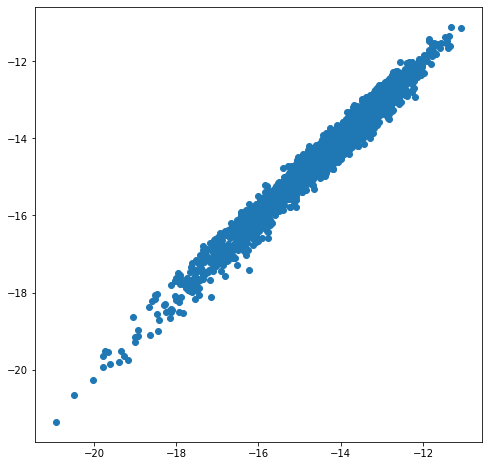

In [67]:
plt.scatter(np.log(cur['all']), np.log(cur['wordle']))
plt.gcf().set_size_inches((8,8))

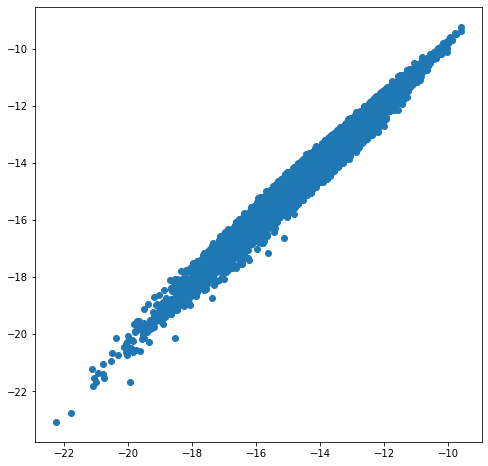

In [68]:
plt.scatter(np.log(wordle['all']), np.log(wordle['wordle']))
plt.gcf().set_size_inches((8, 8))

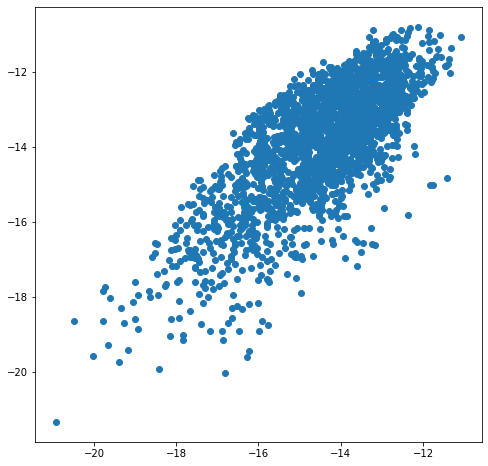

In [70]:
plt.scatter(np.log(cur['all']), np.log(cur['curated']))
plt.gcf().set_size_inches((8, 8))

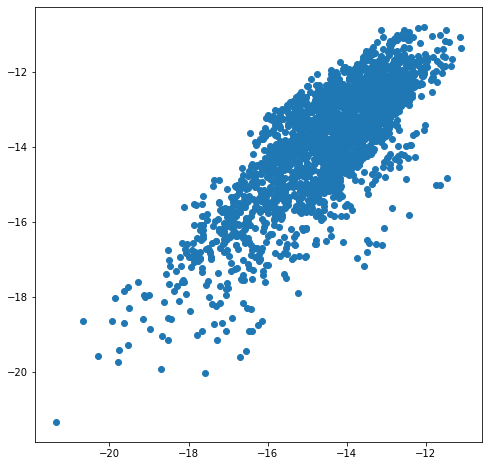

In [69]:
plt.scatter(np.log(cur['wordle']), np.log(cur['curated']))
plt.gcf().set_size_inches((8, 8))